<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite-Difference Method - Acoustic Waves 1D - Optimal Operators</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:

* Implementation of the 1D acoustic wave equation
* Understanding the input parameters for the simulation and the plots that are generated
* Allowing you to explore the finite-difference method with optimal operators

---

### Optimising Operators

Geller and Takeuchi (1995) developed criteria against which the accuracy of frequency-domain calculation of synthetic seismograms could be optimised. This approach was transferred to the time-domain finite-difference method for homogeneous and heterogeneous schemes by Geller and Takeuchi (1998). Look at an optimal operator and compare with the classic scheme. The space-time stencils are illustrated below



$$Conventional-(1/dt^2)$$
<table style="width:25%">
  <tr>
    <td>t+dt</td>
    <td></td>
    <td>1</td>
    <td></td>
  <tr>
    <td>t</td>
    <td></td>
    <td>-2</td>
    <td></td>
  <tr>
    <td>t-dt</td>
    <td></td>
    <td>1</td>
    <td></td>
  <tr>
    <td></td>
    <td>x-dx</td>
    <td>x</td>
    <td>x+dx</td>
  </td>
</table> 

$$Optimal-(1/dt^2)$$
<table style="width:25%">
  <tr>
    <td>t+dt</td>
    <td>1/12</td>
    <td>10/12</td>
    <td>1/12</td>
  <tr>
    <td>t</td>
    <td>-2/12</td>
    <td>-20/12</td>
    <td>-2/12</td>
  <tr>
    <td>t-dt</td>
    <td>1/12</td>
    <td>10/12</td>
    <td>1/12</td>
  <tr>
    <td></td>
    <td>x-dx</td>
    <td>x</td>
    <td>x+dx</td>
  </td>
</table> 


$$Conventional-(1/dx^2)$$
<table style="width:25%">
  <tr>
    <td>t+dt</td>
    <td></td>
    <td></td>
    <td></td>
  <tr>
    <td>t</td>
    <td>1</td>
    <td>-2</td>
    <td>1</td>
  <tr>
    <td>t-dt</td>
    <td></td>
    <td></td>
    <td></td>
  <tr>
    <td></td>
    <td>x-dx</td>
    <td>x</td>
    <td>x+dx</td>
  </td>
</table> 

$$Optimal-(1/dx^2)$$
<table style="width:25%">
  <tr>
    <td>t+dt</td>
    <td>1/12</td>
    <td>-2/12</td>
    <td>1/12</td>
  <tr>
    <td>t</td>
    <td>10/12</td>
    <td>-20/12</td>
    <td>10/12</td>
  <tr>
    <td>t-dt</td>
    <td>1/12</td>
    <td>-2/12</td>
    <td>1/12</td>
  <tr>
    <td></td>
    <td>x-dx</td>
    <td>x</td>
    <td>x+dx</td>
  </td>
</table> 

*The conventional 2nd order finite-difference operators for the 2nd derivative are compared with the optimal operators developed by Geller and Takeuchi (1998), see text for details.*


Note that summing up the optimal operators one obtains the conventional operators. This can be interpreted as a smearing out of the conventional operators in space and time. The optimal operators lead to a locally implicit scheme, as the future of the system at $(x,t+dt)$ depends on values at time level "$t+dt$, i.e., the future depends on the future. That sounds impossible, but it can be fixed by using a predictor-corrector scheme based on the first-order Born approximation.  


The optimal operators perform in a quite spectacular way. With very few extra floating point operations an accuracy improvement of almost an order of magnitude can be obtained. The optimal scheme performs substantially better than the conventional scheme with a 5-point operator.

---

In [7]:
# Import Libraries
# ----------------------------------------------
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Parameter Configuration 
# -----------------------
nt   = 501          # number of time steps
eps  = 1.           # stability limit
xs   = 250          # source location in grid in x-direction
xr   = 450          # receiver location in grid in x-direction

# Material Parameters
# -------------------
rho  = 2500.        # density
c0   = 2000.        # velocity
mu   = rho*(c0**2)  # elastic modulus 

# Space Domain
# ------------
nx   = 2 *xs        # number of grid points in x-direction
dx   = 2.*nx/(nx)   # calculate space increment

# Calculate Time Step from Stability Criterion
# --------------------------------------------
dt   = .5*eps*dx/c0

In [9]:
# Source Time Function 
# --------------------
f0   = 1./(10.*dt) # dominant frequency of the source (Hz)
t0   = 4./f0 # source time shift

# Source Time Function (Gaussian)
# -------------------------------
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2.*(time-t0)*(f0**2)*(np.exp(-1.*(f0**2)*(time-t0)**2))

In [10]:
# Operator Error Calculation 
# --------------------------

# Conventional FD Operators
# -------------------------
A0   = rho / (dt**2) * np.matrix\
('  0.   1.   0.;\
    0.  -2.   0.;\
    0.   1.   0.')
K0   = mu / (dx**2) * np.matrix\
('  0.   0.   0.;\
    1.  -2.   1.;\
    0.   0.   0.')

# Modified FD Operators
# ---------------------
A    = 1. / 12. * rho / (dt**2) * np.matrix\
('  1.  10.   1.;\
   -2. -20.  -2.;\
    1.  10.   1.')
K    = 1. / 12. * mu / (dx**2) * np.matrix\
('  1.  -2.   1.;\
   10. -20.  10.;\
    1.  -2.   1.')

# Calculate Operator Error
# ------------------------
dA   = A0 - A                    # error of conventional operator A
dK   = K0 - K                    # error of conventional operator K
d0   = (dA - dK) * (dt**2) / rho # basic error of modified operator

<IPython.core.display.Javascript object>


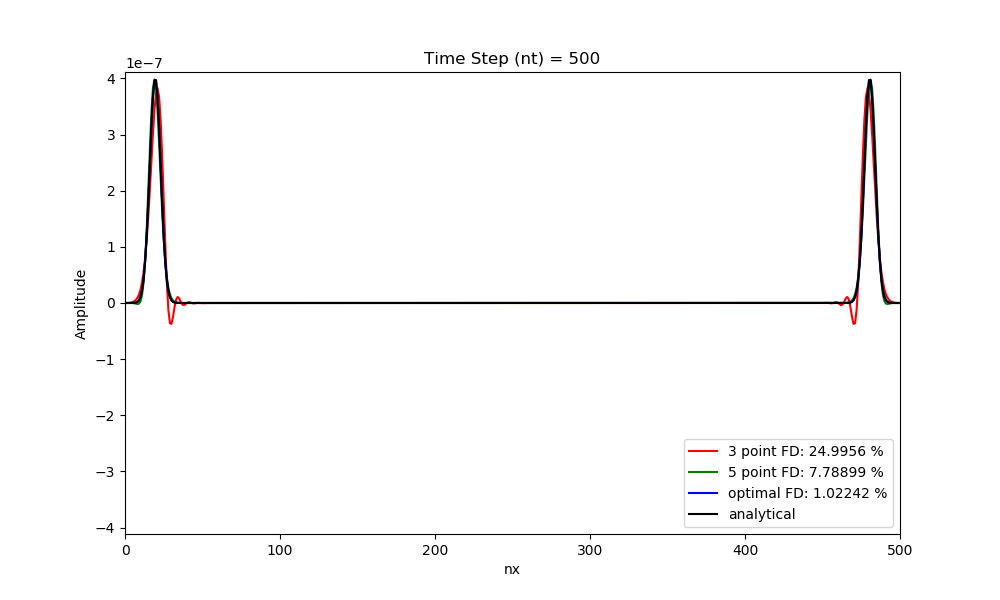

In [11]:
# Snapshot 
# -------------------------------------------

# Initialize Pressure Fields
# --------------------------
p    = np.zeros(nx) # p at time n (now)
pnew = p            # p at time n+1 (present)
pold = p            # p at time n-1 (past)
d2p  = p            # 2nd space derivative of p

mp   = np.zeros(nx) # mp at time n (now)
mpnew= mp           # mp at time n+1 (present)
mpold= mp           # mp at time n-1 (past)
md2p = mp           # 2nd space derivative of mp

op   = np.zeros(nx) # op at time n (now)
opnew= op           # op at time n+1 (present)
opold= op           # op at time n-1 (past)
od2p = op           # 2nd space derivative of op

ap   = np.zeros(nx) # op at time n (now)

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize Coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Initialize Empty Seismogram
# ---------------------------
sp   = np.zeros(nt)
smp  = np.zeros(nt)
sop  = np.zeros(nt)
sap  = np.zeros(nt)

# Plot Position Configuration
# ---------------------------
plt.ion()
fig2 = plt.figure(figsize=(10, 6))
gs2  = gridspec.GridSpec(1, 1, hspace=0.3, wspace=0.3)

# Plot 1D Wave Propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
up31,= ax3.plot(p, 'r') # plot pressure update each time step
up32,= ax3.plot(mp, 'g') # plot pressure update each time step
up33,= ax3.plot(op, 'b') # plot pressure update each time step
up34,= ax3.plot(ap, 'k') # plot pressure update each time step
ax3.set_xlim(0, nx)
lim  = 12. * src.max() * (dx) * (dt**2) / rho
ax3.set_ylim(-lim, lim)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('nx')
ax3.set_ylabel('Amplitude')
error1 = np.sum((np.abs(p  - ap))) / np.sum(np.abs(ap)) * 100
error2 = np.sum((np.abs(mp - ap))) / np.sum(np.abs(ap)) * 100
error3 = np.sum((np.abs(op - ap))) / np.sum(np.abs(ap)) * 100
ax3.legend((up31, up32, up33, up34),\
('3 point FD: %g %%' % error1,\
 '5 point FD: %g %%' % error2,\
 'optimal FD: %g %%' % error3,\
 'analytical'), loc='lower right', fontsize=10, numpoints=1)

plt.show()

In [12]:
# 1D Wave Simulation 
# -------------------------------------------------------

# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    
    # 3 Point Operator FD scheme
    # --------------------------
    for i in range(2, nx - 2):
        d2p[i] = (1. * p[i + 1] - 2. * p[i] + 1. * p[i - 1]) / (dx**2)
    # Time Extrapolation
    pnew = 2. * p - pold + c**2 * d2p * dt**2
    # Add Source Term at xs
    pnew[xs] = pnew[xs] + src[it] * (dx) * (dt**2) / rho
    # Remap Time Levels
    pold, p = p, pnew
    # Set Boundaries Pressure Free
    p[0] = 0.
    p[nx-1] = 0.
    # Seismogram
    sp[it] = p[xr]

    # 5 Point Operator FD scheme
    # --------------------------
    for i in range(2, nx - 2):
        md2p[i] = (-1./12. * mp[i + 2] + 4./3.  * mp[i + 1] - 5./2. * mp[i]\
                   +4./3.  * mp[i - 1] - 1./12. * mp[i - 2]) / (dx**2)
    # Time Extrapolation
    mpnew = 2. * mp - mpold + c**2 * md2p * dt**2 
    # Add Source Term at xs
    mpnew[xs] = mpnew[xs] + src[it] * (dx) * (dt**2) / rho
    # Remap Time Levels
    mpold, mp = mp, mpnew
    # Set Boundaries Pressure Free
    mp[0] = 0.
    mp[nx-1] = 0.
    # Seismogram
    smp[it] = mp[xr]
    
    # Optimal Operator Scheme
    # -----------------------
    for i in range(2, nx - 2):
        od2p[i] = (1. * op[i + 1] - 2. * op[i] + 1. * op[i - 1]) / (dx**2)
    # Time Extrapolation
    opnew = 2. * op - opold + c**2 * od2p * dt**2
    # Calculate Corrector
    odp = op * 0.
    # Corrector at x-dx, x and x+dx
    for i in range(2, nx - 2): 
        odp[i] = opold[i - 1: i + 2] * d0[:, 0]\
               +    op[i - 1: i + 2] * d0[:, 1]\
               + opnew[i - 1: i + 2] * d0[:, 2]
    opnew = opnew + odp
    # Add Source Term at xs
    opnew[xs] = opnew[xs] + src[it] * (dx) * (dt**2) / rho
    # Remap Time Levels
    opold, op = op, opnew
    # Set Boundaries Pressure Free
    op[0] = 0.
    op[nx-1] = 0.
    # Seismogram
    sop[it] = op[xr]
    
    # Analytical Solution
    # ------------------- 
    sig = f0 * dt
    x0  = xs * dx
    it0 = (4./sig)-1.
    ap  =  (np.exp(-(sig)**2 * (x-x0 - c0*(it-it0)*dt)**2)\
          + np.exp(-(sig)**2 * (x-x0 + c0*(it-it0)*dt)**2))
    ap  = ap / np.max([np.abs(ap.min()), np.abs(ap.max())])\
             * np.max([np.abs(op.min()), np.abs(op.max())])
    # Seismogram
    sap[it] = ap[xr]
    
    # Update Data For Wave Propagation Plot
    # -------------------------------------
    idisp = 2 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        up31.set_ydata(p)
        up32.set_ydata(mp)
        up33.set_ydata(op)
        up34.set_ydata(ap)
    
        error1 = np.sum((np.abs(p  - ap))) / np.sum(np.abs(ap)) * 100
        error2 = np.sum((np.abs(mp - ap))) / np.sum(np.abs(ap)) * 100
        error3 = np.sum((np.abs(op - ap))) / np.sum(np.abs(ap)) * 100
        
        ax3.legend((up31, up32, up33, up34),\
        ('3 point FD: %g %%' % error1,\
         '5 point FD: %g %%' % error2,\
         'optimal FD: %g %%' % error3,\
         'analytical'), loc='lower right', fontsize=10, numpoints=1)
        
        plt.gcf().canvas.draw()